In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


In [133]:
stock_samsung = pd.read_csv('Samsung_clean.csv')
stock_samsung

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/4/2010,16060,16180,16000,16180,11978.36523,11950800
1,1/5/2010,16520,16580,16300,16440,12170.84668,27925850
2,1/6/2010,16580,16820,16520,16820,12452.17090,22948850
3,1/7/2010,16820,16820,16260,16260,12037.59082,22107950
4,1/8/2010,16400,16420,16120,16420,12156.04102,14777550
...,...,...,...,...,...,...,...
3887,10/23/2025,96800,98500,96300,96500,96500.00000,18488581
3888,10/24/2025,97900,99000,97700,98800,98800.00000,18801925
3889,10/27/2025,101300,102000,100600,102000,102000.00000,22169970
3890,10/28/2025,100900,101000,99100,99500,99500.00000,20002282


In [134]:
stock_samsung['Date'] = pd.to_datetime(stock_samsung['Date'])
stock_samsung = stock_samsung.set_index(pd.DatetimeIndex(stock_samsung['Date'].values))
df_samsung = pd.DataFrame(stock_samsung, columns=['Close'])


In [135]:
scaler = MinMaxScaler(feature_range=(0,1))
df_samsung_scaled = scaler.fit_transform(np.array(df_samsung).reshape(-1,1))

In [136]:
train_size = int(len(df_samsung_scaled) * 0.6)
val_size = int(len(df_samsung_scaled) * 0.2)
test_size = len(df_samsung_scaled) - train_size - val_size

train_data = df_samsung_scaled[:train_size]
val_data = df_samsung_scaled[train_size:train_size+val_size]
test_data = df_samsung_scaled[train_size+val_size:]


In [137]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100

In [138]:
train_last_window = train_data[-time_step:]
val_data_extended = np.concatenate((train_last_window, val_data), axis=0)
val_last_window = val_data[-time_step:]
test_data_extended = np.concatenate((val_last_window, test_data), axis=0)

X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data_extended, time_step)
X_test, y_test = create_dataset(test_data_extended, time_step)

In [139]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [140]:
from keras.layers import Input

model = Sequential()
# Dùng Input ở layer đầu tiên
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')


In [141]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,        # Số epoch bạn muốn train
    batch_size=32,    # batch size
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - loss: 0.0027 - val_loss: 8.4856e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 4.7697e-04 - val_loss: 7.0890e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 4.3139e-04 - val_loss: 6.6943e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 4.0856e-04 - val_loss: 7.6367e-04
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 3.7500e-04 - val_loss: 6.4601e-04
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 3.7518e-04 - val_loss: 6.7341e-04
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 3.5187e-04 - val_loss: 9.7111e-04
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 3.3165e-04 - val_loss: 5.2458e-04
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 3.4525e-04 - val_loss: 6.8990e-04
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 3.2249e-04 - val_loss: 5.8987e-04
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 3.0965e-04

In [142]:
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [143]:
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
val_mse = mean_squared_error(y_pred_val, y_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_pred_val, y_val)
print(f"Validation MAPE: {val_mape}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MSLE: {val_msle}")

Validation MAPE: 0.024090925903986055
Validation RMSE: 0.01807403633959926
Validation MSLE: 0.00013280232018478876


In [144]:
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
test_mse = mean_squared_error(y_pred_test, y_test)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred_test, y_test)
print(f"Test MAPE: {test_mape}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MSLE: {test_msle}")

Test MAPE: 0.026281952386905907
Test RMSE: 0.020789669355304786
Test MSLE: 0.00016199676875721568


In [145]:
x_input = test_data[5:].reshape(1,-1)
temp_input = list(x_input[0])
prediction_next30_days = []

for i in range(30):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[-time_step:])
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        prediction_next30_days.extend(y_hat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        prediction_next30_days.extend(y_hat.tolist())


In [146]:
last_date = stock_samsung.index.max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=30, freq='D')


In [147]:
prediction_next30_days = scaler.inverse_transform(prediction_next30_days).reshape(-1)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)
train_data_inv = scaler.inverse_transform(train_data) 
val_data_inv = scaler.inverse_transform(val_data)
test_data_inv = scaler.inverse_transform(test_data)

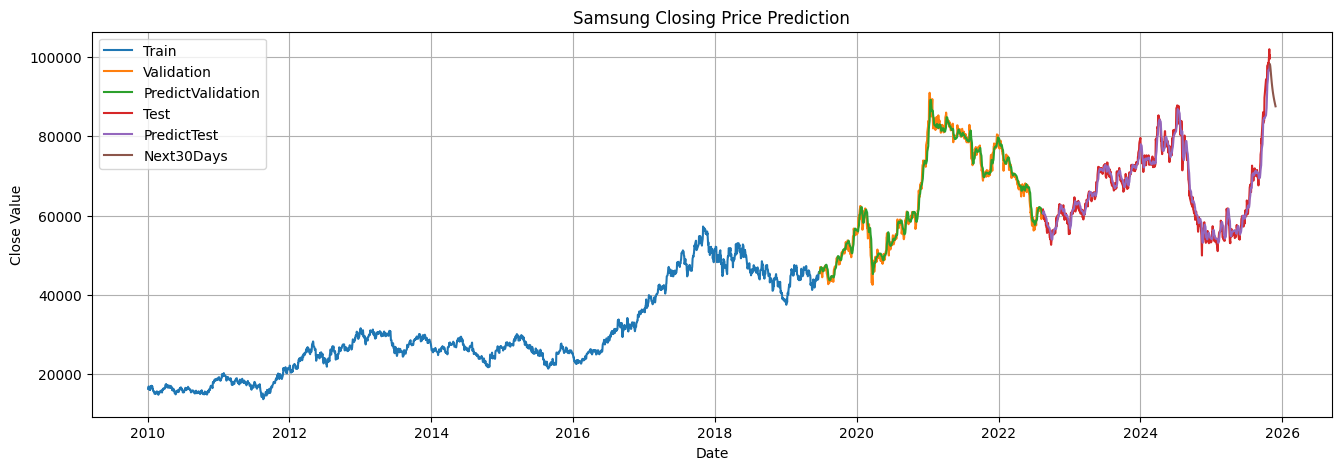

In [148]:
plt.figure(figsize=(16,5))
plt.plot(stock_samsung.index[:train_size], train_data_inv)
plt.plot(stock_samsung.index[train_size:train_size+val_size], val_data_inv)
plt.plot(stock_samsung.index[train_size:train_size+val_size], y_pred_val)
plt.plot(stock_samsung.index[train_size+val_size:], test_data_inv)
plt.plot(stock_samsung.index[train_size+val_size:], y_pred_test)
plt.plot(future_dates, prediction_next30_days)
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Samsung Closing Price Prediction')
plt.legend(['Train','Validation','PredictValidation','Test','PredictTest','Next30Days'])
plt.grid()
plt.show()